In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm  # progress bar
import matplotlib.pyplot as plt
import json
import cv2
import copy
from typing import Optional
import seaborn as sns


!pip install -q pycocotools
from pycocotools.coco import COCO
from PIL import Image
import random
from pathlib import Path
%matplotlib inline
sns.set_theme(style='darkgrid', palette='deep', font='sans-serif', font_scale=1)

from IPython.display import FileLink
# torch
import torch
import gc
import warnings
# Ignore "future" warnings and Data-Frame-Slicing warnings.
warnings.filterwarnings('ignore')



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from pathlib import Path

TRAIN_IMG_DIR = Path("/kaggle/input/dlsprint2/badlad/images/train")

TRAIN_COCO_PATH = Path("/kaggle/input/dlsprint2/badlad/labels/coco_format/train/badlad-train-coco.json")

TEST_IMG_DIR = Path("/kaggle/input/dlsprint2/badlad/images/test")

TEST_METADATA_PATH = Path("/kaggle/input/dlsprint2/badlad/badlad-test-metadata.json")

# Training output directory
OUTPUT_DIR = Path("./output")
OUTPUT_MODEL = OUTPUT_DIR/"model_final.pth"

# Path to your pretrained model weights
PRETRAINED_PATH = Path("")

In [3]:
coco = COCO("../input/dlsprint2/badlad/labels/coco_format/train/badlad-train-coco.json")

loading annotations into memory...
Done (t=6.77s)
creating index...
index created!


In [4]:
ann_ids = coco.getAnnIds()
anns = coco.loadAnns(ann_ids)

cat_ids = [ann["category_id"] for ann in anns]
img_ids = [ann["image_id"] for ann in anns]

ann_ids = pd.Series(ann_ids)
cat_ids = pd.Series(cat_ids)
img_ids = pd.Series(img_ids)
img_ids
cat_ids

0         0
1         0
2         2
3         1
4         1
         ..
425096    1
425097    1
425098    1
425099    1
425100    1
Length: 425101, dtype: int64

In [5]:
def organize_coco_data(data_dict: dict) -> tuple[list[str], list[dict], list[dict]]:
    thing_classes: list[str] = []

    # Map Category Names to IDs
    for cat in data_dict['categories']:
        thing_classes.append(cat['name'])

    # Images
    images_metadata: list[dict] = data_dict['images']
    return thing_classes, images_metadata

In [6]:
### Data Load ###

import json
from pathlib import Path

TEST_METADATA_PATH = Path("/kaggle/input/dlsprint2/badlad/badlad-test-metadata.json")
with TEST_METADATA_PATH.open() as f:
    test_dict = json.load(f)
thing_classes_test, images_metadata_test = organize_coco_data(test_dict)
test_metadata = pd.DataFrame(images_metadata_test)
test_metadata = test_metadata[['id', 'file_name', 'width', 'height']]
test_metadata = test_metadata.rename(columns={"id": "image_id"})
print("test_metadata size=", len(test_metadata))
test_metadata.head(5)

test_metadata size= 13000


,image_id,file_name,width,height
0,0,96eee398-1275-4768-be89-ec945e6c8bb0.png,720,1018
1,1,9b77c241-8292-4133-ab7a-0398a99f30a8.png,720,1019
2,2,3a6ac54b-d3f6-4783-9f71-b6ae29c93f7d.png,720,1105
3,3,2d0e29cd-83cb-4426-9663-1368c1975c37.png,1080,1920
4,4,f8c22a4a-6c89-4179-8845-12405bfd0035.png,1080,1920


In [7]:
test_metadata = pd.DataFrame(images_metadata_test)
test_metadata = test_metadata[['id', 'file_name', 'width', 'height']]
test_metadata = test_metadata.rename(columns={"id": "image_id"})
print("test_metadata size=", len(test_metadata))
test_metadata.head(5)

test_metadata size= 13000


,image_id,file_name,width,height
0,0,96eee398-1275-4768-be89-ec945e6c8bb0.png,720,1018
1,1,9b77c241-8292-4133-ab7a-0398a99f30a8.png,720,1019
2,2,3a6ac54b-d3f6-4783-9f71-b6ae29c93f7d.png,720,1105
3,3,2d0e29cd-83cb-4426-9663-1368c1975c37.png,1080,1920
4,4,f8c22a4a-6c89-4179-8845-12405bfd0035.png,1080,1920


0 96eee398-1275-4768-be89-ec945e6c8bb0.png
1 9b77c241-8292-4133-ab7a-0398a99f30a8.png
2 3a6ac54b-d3f6-4783-9f71-b6ae29c93f7d.png


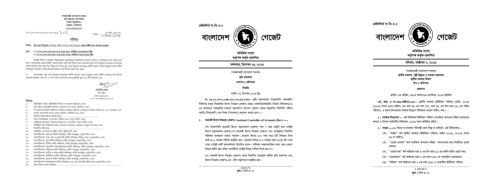

In [8]:
for index, row in test_metadata.iterrows():
    print(row['image_id'],   row['file_name'])
    image_file=row['file_name']
    image = Image.open(TEST_IMG_DIR/image_file)
    code = 231 + row['image_id'];
    plt.subplot(code)
    plt.axis('off')
    plt.imshow(np.asarray(image))
    if row["image_id"]==2:
        break

In [9]:
# Installing necessary dependencies
!pip install -q ultralytics pycocotools

In [10]:
from ultralytics import YOLO
model = YOLO('/kaggle/input/best20/best.pt')

In [11]:
import numpy as np

def bbox_to_mask(image_shape, bounding_boxs):
    
    binary_mask = np.zeros(image_shape, dtype=np.uint8)

    x_min, y_min, x_max, y_max = bounding_boxs

    # Update the corresponding region in the binary mask
    binary_mask[y_min:y_max, x_min:x_max] = 1

    return binary_mask

In [12]:
def rle_encode(mask):
    pixels = mask.T.flatten()
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return ' '.join(str(x) for x in rle)


In [13]:
catagory=[0,1,2,3]

In [14]:
submission_file = open("submission.csv", "w")
submission_file.write("Id,Predicted\n")

13

In [15]:
for index, row in test_metadata.iterrows():
    #print(row['image_id'],   row['file_name'])
    image_file=row['file_name']
    image = Image.open(TEST_IMG_DIR/image_file)
    #code = 231 + row['image_id'];
    #plt.subplot(code)
    #plt.axis('off')
    #plt.imshow(np.asarray(image))
    #if row["image_id"]==3:
        #break
    results=model.predict(image,conf=0.3)
    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs
    b=boxes.cls.short().to("cpu").numpy()
    for cat in catagory:
        a=np.where(b==cat)
        image_shape=boxes.orig_shape
        combined_mask = np.zeros(image_shape, dtype=np.uint8)
        for a1 in a[0]:
        
            box1 = boxes[a1]  #returns one box
            box1.xyxy
            z1=torch.squeeze(box1.xyxy) #squeeze one dimention 
            c1=z1.short().to("cpu").numpy() #convert tensor array to numpy array

            mask1=bbox_to_mask(boxes.orig_shape,c1) #from bbox to mask
            combined_mask=np.logical_or(combined_mask,mask1) #summimg all the same catagorical mask

            #plot the combine masks

            #plt.subplot(1,len(catagory),(cat+1))
            #plt.imshow(combined_mask)
        
        rle=rle_encode(combined_mask)

        results: list[str] = []
        results = [ f"{row['image_id']}_{cat},{rle}\n"]
        submission_file.writelines(results)
        results = []


0: 640x480 2 paragraphs, 52 text_boxs, 1 image, 77.0ms
Speed: 15.6ms preprocess, 77.0ms inference, 19.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 3 paragraphs, 14 text_boxs, 1 image, 13.4ms
Speed: 2.2ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 6 paragraphs, 21 text_boxs, 1 image, 66.9ms
Speed: 2.0ms preprocess, 66.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 2 paragraphs, 14 text_boxs, 1 image, 71.9ms
Speed: 2.1ms preprocess, 71.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 paragraphs, 18 text_boxs, 1 image, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 3 paragraphs, 27 text_boxs, 1 image, 14.2ms
Speed: 2.6ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x384 10 paragraphs, 18 text_boxs, 13.6ms
Speed: 2.2ms preprocess, 13.6ms 

In [16]:
submission_file.close()
from pathlib import Path
if Path("submission.csv").exists:
    display("submission.csv")

'submission.csv'

In [17]:
if Path("submission.csv").exists:
    display(FileLink("submission.csv"))

/kaggle/working/submission.csv